### 使用pythorch加速运算的lowrankSNN
#### lowrank 给EtoE的连接
#### 视synaptic current为活动
#### 添加bias current

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch.distributions as dist
from functions import Draw_Output, Draw_Conductance, Draw_RasterPlot, Draw_Voltage, Draw_Projection, save_model, load_config_yaml
from functions import load_init
from lowranksnn import LowRankSNN
plt.rcParams.update({'font.size': 30})  


In [2]:
# Read the configuration file
# config = load_config_yaml('config.yaml')
# config = load_config_yaml('config_ING_gamma.yaml')
# config = load_config_yaml('config_go_nogo_diff.yaml')
config = load_config_yaml('config_test.yaml')
# config = load_config_yaml('config_test_phase_sensitivity.yaml')

N_E = config['N_E']
N_I = config['N_I']
N = N_E + N_I
P_EE = config['P_EE']
P_EI = config['P_EI']
P_IE = config['P_IE']
P_II = config['P_II']
factor_mn = config['factor_mn'] # 组合成conn时乘在lowrank matrix上的常數
RS = config['RandomStrength'] # 组合成conn时乘在random matrix上的常數

taud_E = config['taud_E']
taud_I = config['taud_I']
# ratio_fast = config['ratio_fast']
# if type(taud_E) == list: # introduce fast and slow time constants
#     mask_tauE = torch.rand(1, N_E) < ratio_fast
#     mask_tauI = torch.rand(1, N_I) < ratio_fast
#     tau_E = torch.ones(1, N_E) * taud_E[1]
#     tau_E[mask_tauE] = taud_E[0]
#     tau_I = torch.ones(1, N_I) * taud_I[1]
#     tau_I[mask_tauI] = taud_I[0]
#     taud_E = tau_E.tolist()
#     taud_I = tau_I.tolist()

eta_E = config['eta_E']
eta_I = config['eta_I']
delta_E = config['delta_E']
delta_I = config['delta_I']

mu = config['mu']
si = config['sigma']
# mu_rand = config['mu_rand']

si_rand = config['sigma_rand']
dt = config['dt'] #(ms/step)
T_pre = config['T_pre'] # length of time before sti (ms)
T_sti = config['T_sti'] # length of time for sti (ms)
T_after = config['T_after'] # length of time after sti (ms)
T = T_pre+T_sti+T_after # length of Period time (ms): 30ms

IS = config['InputStrength'] #Input Strength (maybe chage to norm in the future)

color_Go = config['color_Go']
color_Nogo = config['color_Nogo']


In [3]:
# Functions
def Generate_Vectors(N, mu=0, sigma=0.1,seed=None):
    # seed: random seed
    # m,n,sti_nogo 从 gaussian 分布中采样
    if seed:
        m = torch.normal(mu, sigma, (N,1), generator=seed)
        n = torch.normal(mu, sigma, (N,1), generator=seed)
        sti_nogo = torch.normal(mu, sigma, (N,1), generator=seed)
    else:
        m = torch.normal(mu, sigma, (N,1))
        n = torch.normal(mu, sigma, (N,1))
        sti_nogo = torch.normal(mu, sigma, (N,1))
    return m, n, sti_nogo

In [4]:
# Functions

def ab_gamma(mu, sigma):
    # mu: mean of gamma distribution
    # sigma: standard deviation of gamma distribution
    # return a, b parameters of gamma distribution
    # a = mu^2/sigma^2, b = mu/sigma^2
    a = mu ** 2 / sigma ** 2
    b = mu / sigma ** 2
    return a, b

def show_mn(m,n,Sti_nogo,factor_mn):

    # draw the vectors m, n, Sti_nogo in heatmap
    plt.figure()
    plt.imshow(torch.cat((m, n, Sti_nogo), 1), aspect='auto',interpolation='nearest')
    plt.colorbar()
    plt.title('Vectors m, n, Sti_nogo')
    plt.show()
    print("m norm:", torch.norm(m))
    print("n norm:", torch.norm(n))
    print("Sti_nogo norm:", torch.norm(Sti_nogo))

    # W_rank1 = factor_mn*(torch.ger(m.squeeze(), n.squeeze()))
    # W_rank1 = factor_mn*torch.abs(torch.ger(m.squeeze(), n.squeeze()))
    W_rank1 = factor_mn*torch.ger(m.squeeze(), n.squeeze())
    #draw the rank-1 matrix
    plt.figure()
    plt.imshow(W_rank1,interpolation='nearest')
    plt.colorbar()
    plt.title('Rank-1 matrix')
    plt.show()
    # 展示各部分的平均值
    print("Rank-1 matrix average value_EtoE:", torch.mean(W_rank1[:N_E, :N_E]))
    print("Rank-1 matrix average value_EtoI:", torch.mean(W_rank1[:N_E, N_E:]))
    print("Rank-1 matrix average value_ItoE:", torch.mean(W_rank1[N_E:, :N_E]))
    print("Rank-1 matrix average value_ItoI:", torch.mean(W_rank1[N_E:, N_E:]))
    return W_rank1
# W_rank1 = show_mn(m,n,Sti_nogo,factor_mn)

def Generate_RandomMatrix(N_E, N_I, P_EE, P_EI, P_IE, P_II, W_rank1, sigma=0.1):
    # Construct random weight matrix
    # use beta distribution to generate random matrix
    # W_rank1: low rank matrix
    # deside the average value of the beta distribution according to the rank-1 matrix to make sure
    # the average value of the sum of the rank-1 matrix and the random matrix is according to the P_EE, P_EI, P_IE, P_II
    N = N_E + N_I
    W = torch.zeros(N, N)

    mu_EE = P_EE - torch.sum(W_rank1[:N_E, :N_E]) / (N_E * N_E)
    mu_EI = P_EI - torch.sum(W_rank1[:N_E, N_E:]) / (N_E * N_I)
    mu_IE = P_IE - torch.sum(W_rank1[N_E:, :N_E]) / (N_I * N_E)
    mu_II = P_II - torch.sum(W_rank1[N_E:, N_E:]) / (N_I * N_I)

    # 生成a,b参数
    # 打印出来看看
    a_EE, b_EE = ab_gamma(mu_EE, sigma)
    a_EI, b_EI = ab_gamma(mu_EI, sigma)
    a_IE, b_IE = ab_gamma(mu_IE, sigma)
    a_II, b_II = ab_gamma(mu_II, sigma)

    # print("a_EE, b_EE, average value:", a_EE, b_EE, mu_EE)
    # print("a_EI, b_EI, average value:", a_EI, b_EI, mu_EI)
    # print("a_IE, b_IE, average value:", a_IE, b_IE, mu_IE)
    # print("a_II, b_II, average value:", a_II, b_II, mu_II)

    # 生成连接矩阵
    W[:N_E, :N_E] = dist.Gamma(a_EE,b_EE).sample((N_E,N_E))
    W[:N_E, N_E:] = dist.Gamma(a_EI, b_EI).sample((N_E, N_I))
    W[N_E:, :N_E] = dist.Gamma(a_IE, b_IE).sample((N_I, N_E))
    W[N_E:, N_E:] = dist.Gamma(a_II, b_II).sample((N_I, N_I))
    return W

# test the function
def show_conn(N,N_E, N_I, P_EE, P_EI, P_IE, P_II,W_rank1,RS,W_random=None):
    if W_random is None:
        W_random = Generate_RandomMatrix(N_E, N_I, P_EE, P_EI, P_IE, P_II, W_rank1)
    # rank = np.linalg.matrix_rank(W_random)
    # print("矩阵的秩:", rank)
    # print("非零元素的比例:", np.count_nonzero(W_random) / (N * N))

    plt.figure()
    plt.imshow(W_random,interpolation='nearest')
    plt.colorbar()
    plt.title('Full Rank matrix')
    plt.show()
    # 展示各部分的平均值
    print("Full Rank matrix average value_EtoE:", torch.mean(W_random[:N_E, :N_E]))
    print("Full Rank matrix average value_EtoI:", torch.mean(W_random[:N_E, N_E:]))
    print("Full Rank matrix average value_ItoE:", torch.mean(W_random[N_E:, :N_E]))
    print("Full Rank matrix average value_ItoI:", torch.mean(W_random[N_E:, N_E:]))

    W_conn = W_rank1 + RS * W_random
    W_conn[W_conn > 1] = 1
    W_conn[W_conn < 0] = 0
    plt.figure()
    plt.imshow(W_conn,interpolation='nearest')
    plt.colorbar()
    plt.title('Connectivity matrix')
    plt.show()
    # 展示各部分的平均值
    print("Connectivity matrix average value_EtoE:", torch.mean(W_conn[:N_E, :N_E]))
    print("Connectivity matrix average value_EtoI:", torch.mean(W_conn[:N_E, N_E:]))
    print("Connectivity matrix average value_ItoE:", torch.mean(W_conn[N_E:, :N_E]))
    print("Connectivity matrix average value_ItoI:", torch.mean(W_conn[N_E:, N_E:]))
    return W_conn



In [5]:
# Initialiazation
LRSNN = LowRankSNN(N_E=N_E,N_I=N_I,taud_E=taud_E,taud_I=taud_I,RS=RS)

# Go_NoGo Task
# Prepare the Low Rank Connectivity (Rank = 1), Stimuli and Readout Vector
m, n, Sti_nogo = Generate_Vectors(N, mu, si)
m[N_E:] = 0
n[N_E:] = 0
Sti_nogo[N_E:] = 0
Sti_go = n.clone()
W_out = m.clone()

# W_rank1 = factor_mn*(torch.ger(m.squeeze(), n.squeeze()))/N
# W_rank1 = factor_mn*(torch.ger(m.squeeze(), n.squeeze()))
# W_rank1 = factor_mn*torch.abs(torch.ger(m.squeeze(), n.squeeze()))
W_rank1 = factor_mn*torch.ger(m.squeeze(), n.squeeze())
conn_rand = Generate_RandomMatrix(N_E, N_I, P_EE, P_EI, P_IE, P_II, W_rank1, sigma = si_rand)
# W_rank1 = torch.abs(W_rank1)
Sti_go = n.clone()

In [6]:
# Assemble the Network
LRSNN.add_lowrank(W_rank1, W_out)
LRSNN.add_random(conn_rand)
# LRSNN.add_random(torch.zeros(N,N))
LRSNN.conn[LRSNN.conn>1] = 1
LRSNN.conn[LRSNN.conn<0] = 0

Low Rank connection and readout vector have been added.
Random connection has been added.


In [7]:
# print(np.dot(Sti_go.squeeze(),Sti_nogo.squeeze()))
# print(np.dot(Sti_go.squeeze(),W_out.squeeze()))
# print(np.dot(Sti_nogo.squeeze(),W_out.squeeze()))

# print('max(W_rank1):',torch.max(W_rank1).data.numpy(),
#       ', max(conn_rand):',torch.max(conn_rand).data.numpy(), 
#       ', max(conn):',torch.max(LRSNN.conn).data.numpy())
# show_mn(m,n,Sti_nogo,factor_mn)
# _ = show_conn(N,N_E, N_I, P_EE, P_EI, P_IE, P_II,W_rank1,RS)

In [8]:
T = T_pre+T_sti+T_after # length of Period time (ms）

Input_go = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt))) #size:(N,time)
Input_go[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_go
Input_nogo = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt)))
Input_nogo[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_nogo

# duplicate the input for twice
Input_go = torch.cat((Input_go,Input_go),1)
Input_nogo = torch.cat((Input_nogo,Input_nogo),1)

# bias current (according to sugino's code)
# Eta = [0, 10]; % 定常電流の平均値
# Delta = [0, 0.05]; % 定常電流のHMHW
# I_E = Eta(1)+Delta(1)*tan(pi*((1:N_E)'/(N_E+1)-1/2)); % 流入電流(E)
# I_I = Eta(2)+Delta(2)*tan(pi*((1:N_I)'/(N_I+1)-1/2)); % 流入電流(I)
bias = torch.zeros_like(Input_go)
bias[:N_E,:] = (eta_E+delta_E*torch.tan(torch.tensor(np.pi*(np.arange(1,N_E+1)/(N_E+1)-1/2)))).unsqueeze(1)
bias[N_E:,:] = (eta_I+delta_I*torch.tan(torch.tensor(np.pi*(np.arange(1,N_I+1)/(N_I+1)-1/2)))).unsqueeze(1)

# Input_go += bias
# Input_nogo += bias

#将模型及相应属性移动到GPU
device = torch.device('cuda:0')
LRSNN = LRSNN.to(device)
Input_go = Input_go.to(device)
Input_nogo = Input_nogo.to(device)
bias = bias.to(device)

# Start Simulation
Out_go, V_go, g_go, I_syn_go, spk_step_go, spk_ind_go,_,_ = LRSNN(dt,Input_go+bias)
Out_nogo, V_nogo, g_nogo, I_syn_nogo, spk_step_nogo, spk_ind_nogo,_,_ = LRSNN(dt,Input_nogo+bias)


g_go_EE = g_go[1]
g_nogo_EE = g_nogo[1]
# Out_go = torch.matmul(LRSNN.W_out[:N_E].T, g_go_EE).squeeze()
# Out_nogo = torch.matmul(LRSNN.W_out[:N_E].T, g_nogo_EE).squeeze()
prop = torch.max(Out_go)/torch.max(Out_nogo)
print('Performance: ', prop.item())


Start Simulation
Simulation Finished
Start Simulation
Simulation Finished
Performance:  1.6750075817108154


In [9]:
# 处理绘图用的数据以使其能够在cpu上运行
Out_go = Out_go.cpu().numpy()
Out_nogo = Out_nogo.cpu().numpy()
Input_go = Input_go.cpu().numpy()
Input_nogo = Input_nogo.cpu().numpy()
g_go = [g.cpu().numpy() for g in g_go]
g_nogo = [g.cpu().numpy() for g in g_nogo]
g_go_EE = g_go[1]
g_nogo_EE = g_nogo[1]
V_go = V_go.cpu().numpy()
V_nogo = V_nogo.cpu().numpy()
I_syn_go = [I.cpu().numpy() for I in I_syn_go]
I_syn_nogo = [I.cpu().numpy() for I in I_syn_nogo]
I_syn_go_EE = I_syn_go[1]
I_syn_nogo_EE = I_syn_nogo[1]

# spk_go = spk_go.cpu().numpy()
# spk_nogo = spk_nogo.cpu().numpy()
m = m.cpu().numpy()
n = n.cpu().numpy()
Sti_go = Sti_go.cpu().numpy()
Sti_nogo = Sti_nogo.cpu().numpy()

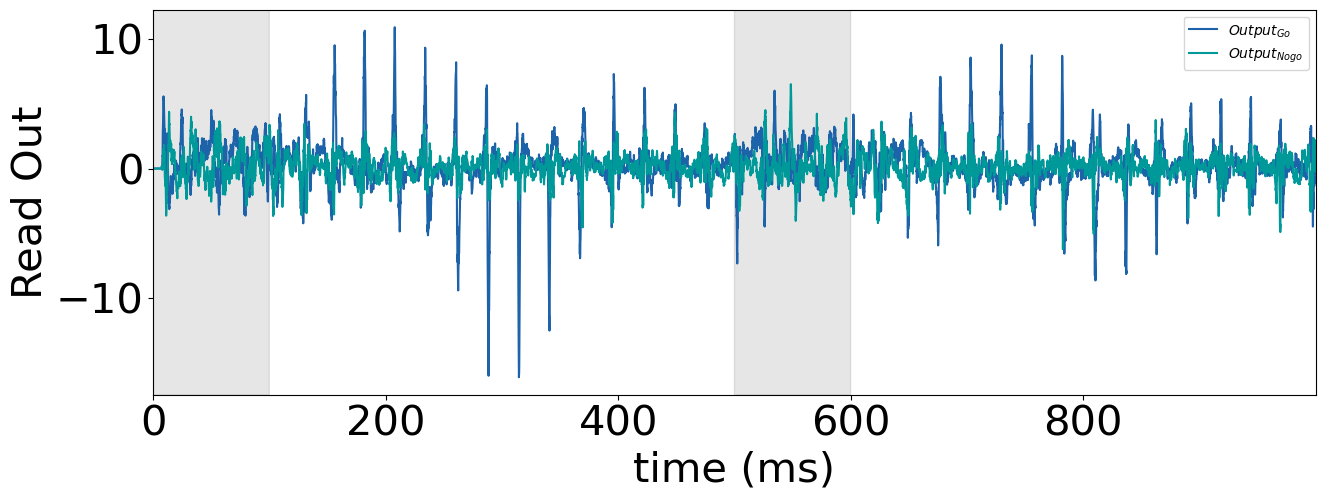

In [10]:
# Draw Output

# Functions for drawing
def Draw_Output(ax,data,label_data,dt,input_data,color_data='#1C63A9'):
    # tt = np.linspace(0,len(data)-1)*dt
    # input_data: size:(N,time)
    tt = np.array(range(len(data)))*dt
    ax.plot(tt,data,color = color_data, label = '$'+label_data+'$')

    ax.set_xlabel('time (ms)')
    ax.set_ylabel('Read Out')

    ax.set_xlim([0, tt[-1]])
    ax.set_ylim([np.min([0,np.min(data),ax.get_ylim()[0]]), np.max([0.0000001,np.max(data),ax.get_ylim()[1]])])
    # shade the stimulus period (where the input is not zero)
    ax.fill_between(tt, ax.get_ylim()[0], ax.get_ylim()[1], where=input_data[0].squeeze()!=0, color='gray', alpha=0.1)
    ax.legend(loc = 1, prop={'size':10})


fig, ax = plt.subplots(figsize=(15,5))
Draw_Output(ax,Out_go,'Output_{Go}',dt,Input_go,color_data = color_Go)
Draw_Output(ax,Out_nogo,'Output_{Nogo}',dt,Input_nogo,color_data=color_Nogo)


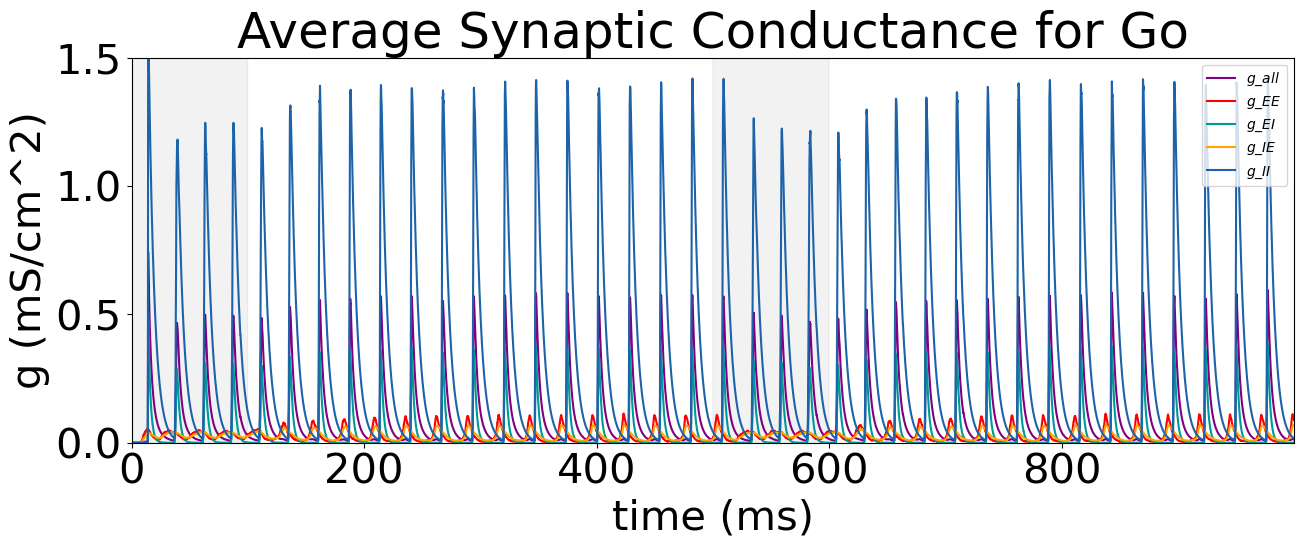

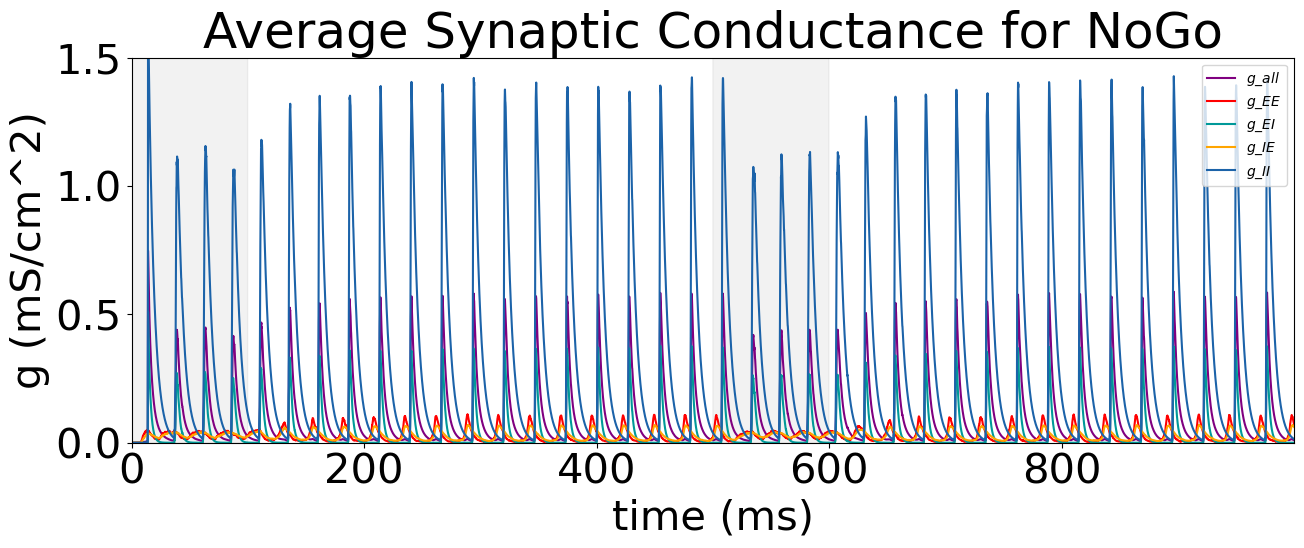

In [11]:

# Monitor the Average Conductance
# Average of summary of synaptic conductance from a group of neurons to a single neuron
tag = ['g\_all','g\_EE','g\_EI','g\_IE','g\_II']
colors = ['#800080','#FF0000','#009999','#FFA500','#1C63A9']
y_lim = [0,1.5]
fig, ax = plt.subplots(figsize=(15,5))
Draw_Conductance(ax,g_go,colors,tag,dt,Input_go,ylim=y_lim,title="Average Synaptic Conductance for Go")
fig, ax = plt.subplots(figsize=(15,5))
Draw_Conductance(ax,g_nogo,colors,tag,dt,Input_nogo,ylim=y_lim,title="Average Synaptic Conductance for NoGo")


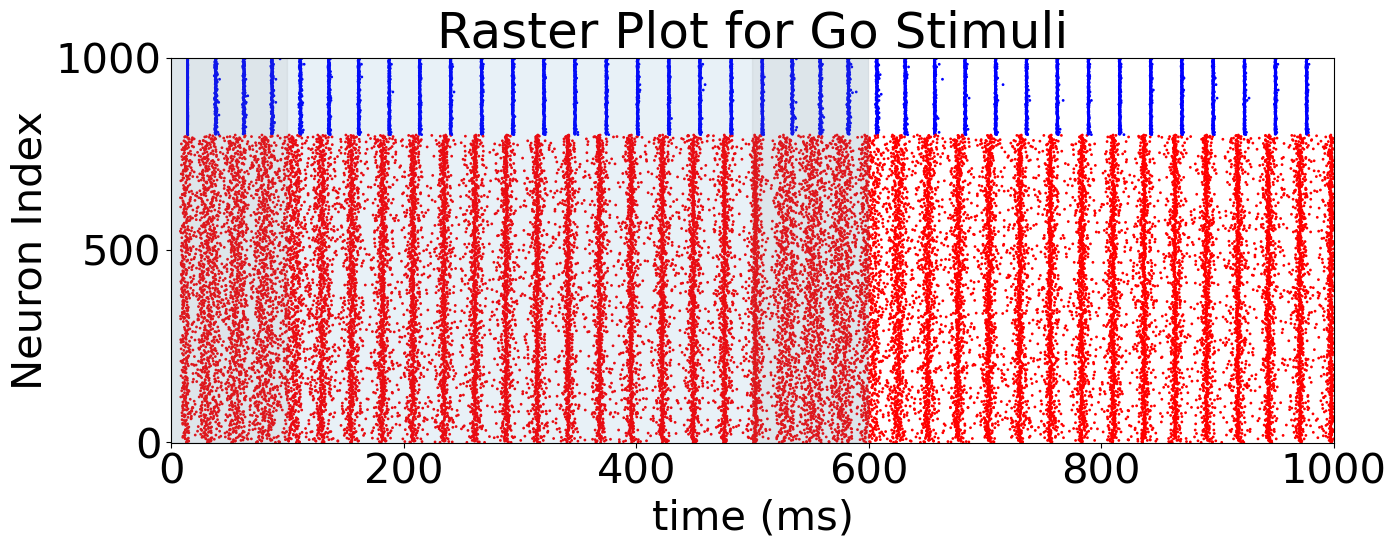

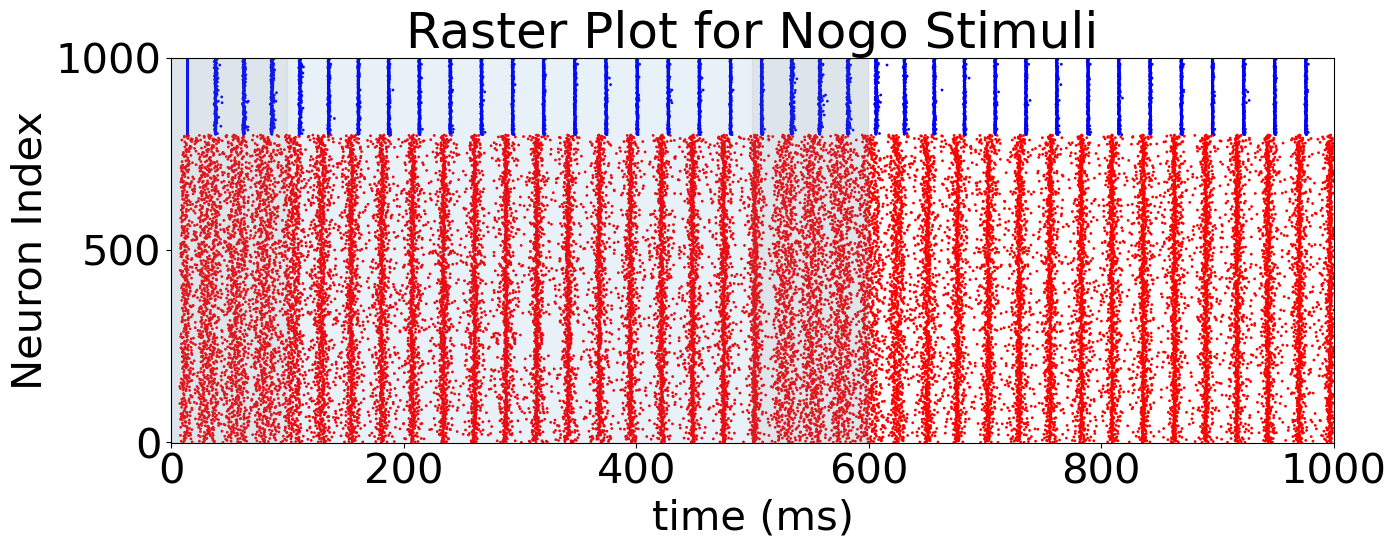

In [12]:

# Raster Plot
fig, ax = plt.subplots(figsize=(15,5))
Draw_RasterPlot(ax,spk_step_go, spk_ind_go,'Raster Plot for Go Stimuli',dt,Input_go,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())
fig, ax = plt.subplots(figsize=(15,5))
Draw_RasterPlot(ax,spk_step_nogo,spk_ind_nogo,'Raster Plot for Nogo Stimuli',dt,Input_nogo,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())


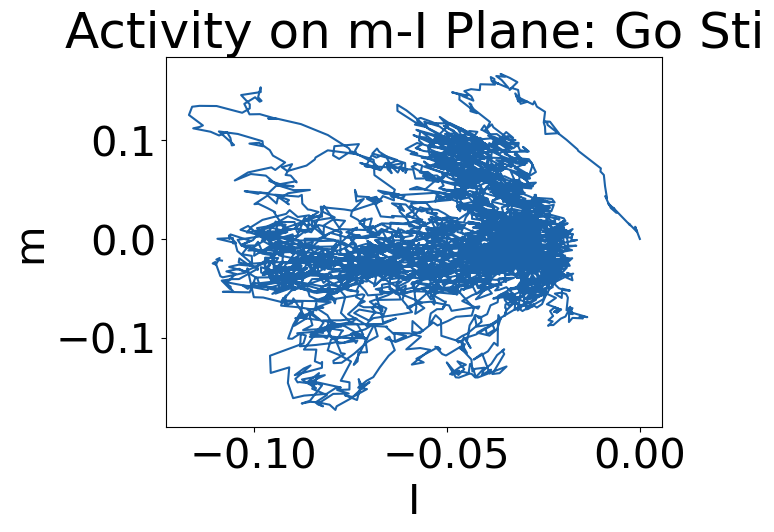

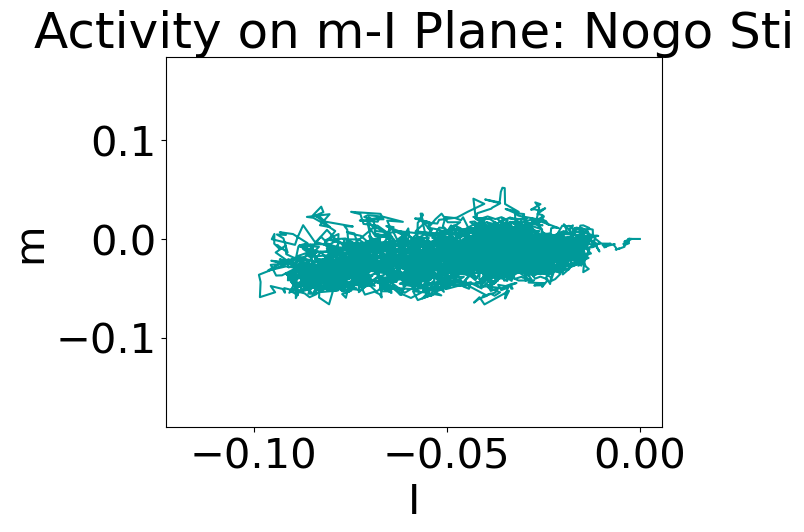

In [78]:

# Monitor the Projection on m-I plane
fig, ax = plt.subplots()
ylim,xlim = Draw_Projection(ax,g_go_EE,Sti_go[:N_E],m[:N_E],'Activity on m-I Plane: Go Sti',color_Go,xlabel='I',ylabel='m')
fig, ax = plt.subplots()
ylim,xlim = Draw_Projection(ax,g_nogo_EE,Sti_nogo[:N_E],m[:N_E],'Activity on m-I Plane: Nogo Sti',color_Nogo,xlabel='I',ylabel='m',ylim=ylim,xlim=xlim)

In [151]:
# Out = I_syn_go_EE.T@LRSNN.W_out[:LRSNN.N_E] # size(T,1)
# fig, ax = plt.subplots(figsize=(15,5))
# Draw_Output(ax,Out,'Output_{Go}',dt,Input_go,color_data = color_Go)

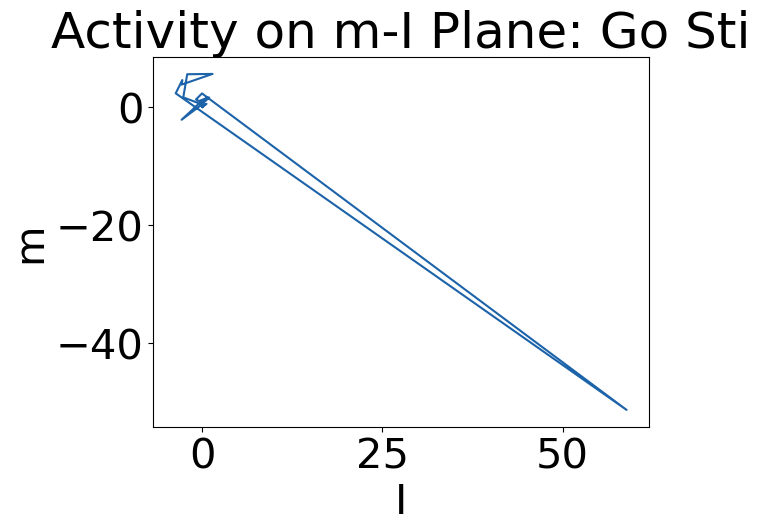

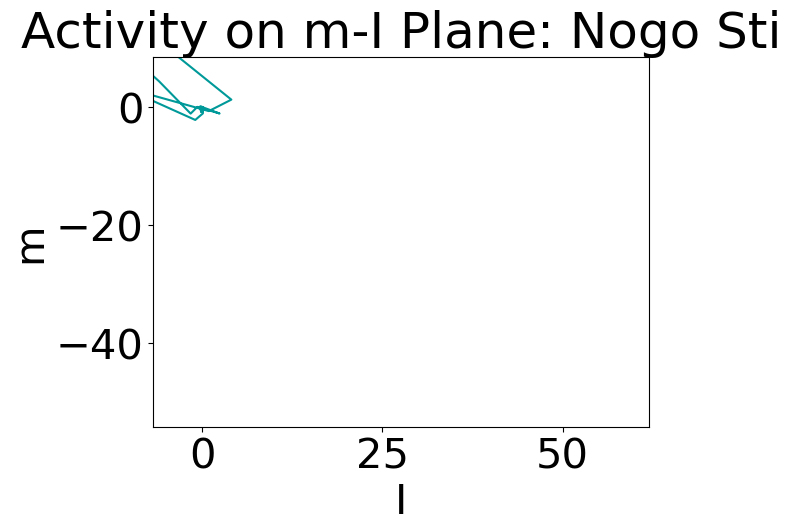

In [341]:
# Monitor the Projection on m-I plane
fig, ax = plt.subplots()
ylim,xlim = Draw_Projection(ax,I_syn_go_EE,Sti_go[:N_E],m[:N_E],'Activity on m-I Plane: Go Sti',color_Go,xlabel='I',ylabel='m')
fig, ax = plt.subplots()
ylim,xlim = Draw_Projection(ax,I_syn_nogo_EE,Sti_nogo[:N_E],m[:N_E],'Activity on m-I Plane: Nogo Sti',color_Nogo,xlabel='I',ylabel='m',ylim=ylim,xlim=xlim)

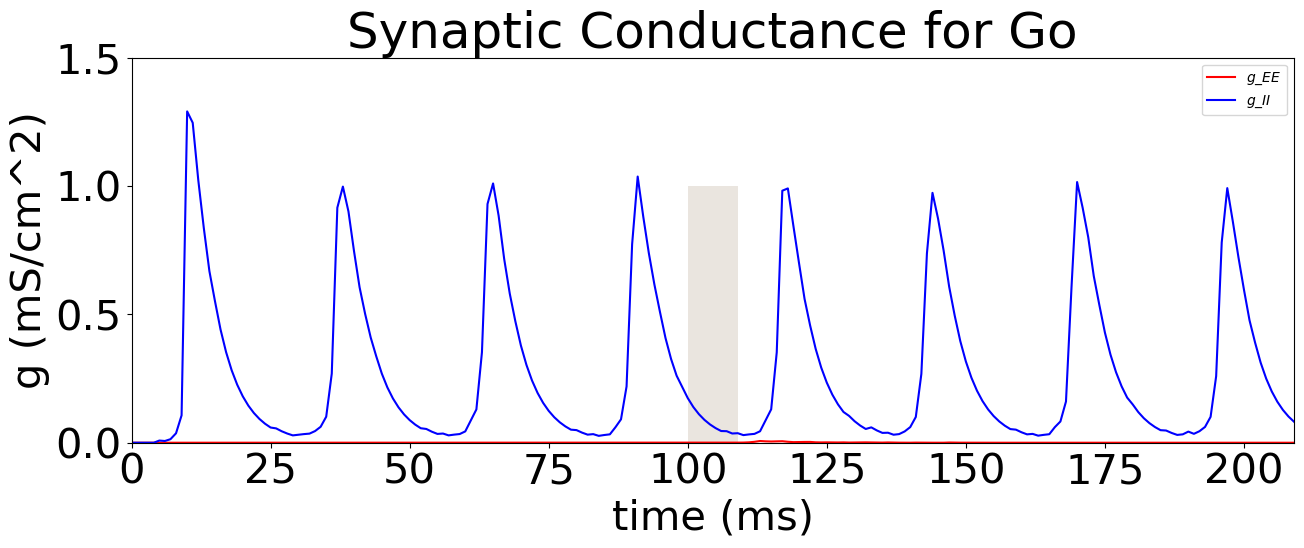

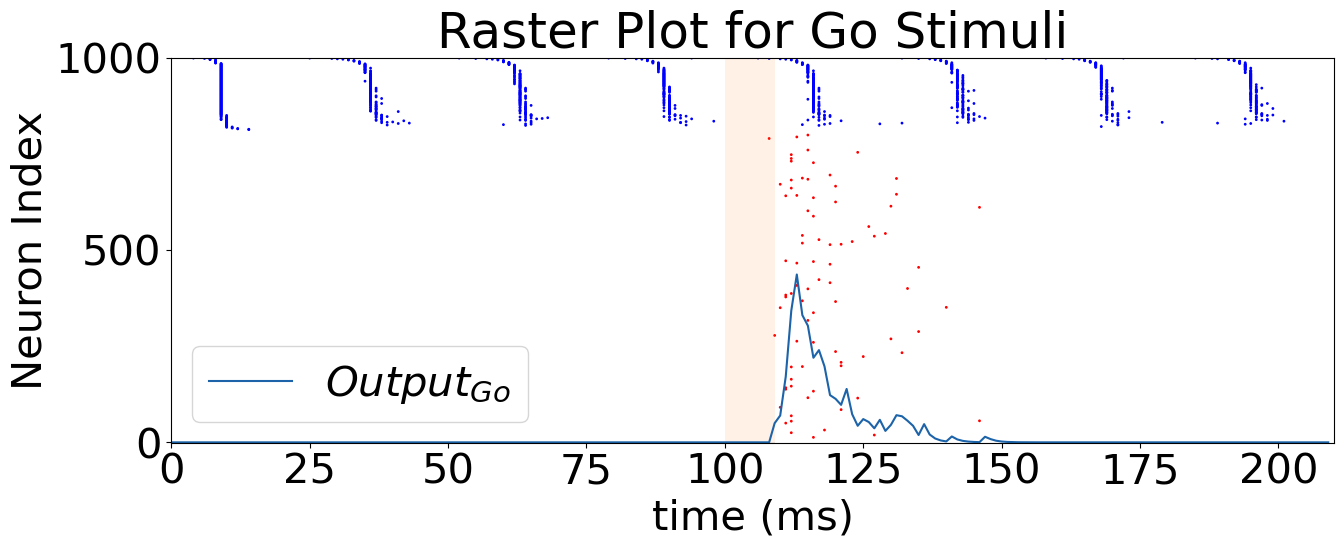

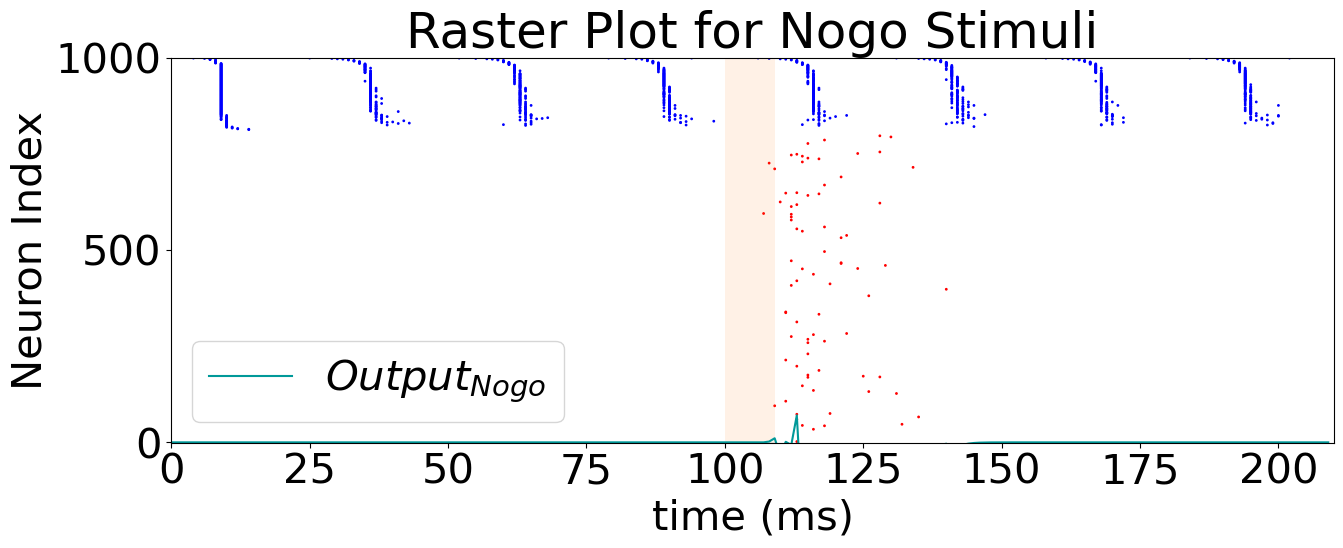

In [339]:
#draw the conductance of Excitatory and Inhibitory neurons
# color for Excitatory: red
# color for Inhibitory: blue
color_Exc = 'red'
color_Inh = 'blue'
fig, ax = plt.subplots(figsize=(15,5))
Draw_Conductance(ax,g_go[1],color_Exc,"g\_EE",dt,Input_go,ylim=y_lim,title="Synaptic Conductance for Go")
Draw_Conductance(ax,g_go[-1],color_Inh,"g\_II",dt,Input_nogo,ylim=y_lim)

# Plot the raster plot and the output together for Go and Noto
plt.rcParams.update({'font.size': 30})  
fig, ax = plt.subplots(figsize=(15,5))
Draw_Output(ax,Out_go*100,'Output_{Go}',dt,Input_go,color_data = color_Go)
Draw_RasterPlot(ax,spk_step_go, spk_ind_go,'Raster Plot for Go Stimuli',dt,Input_go,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())
plt.legend(fontsize=30)  # 设置图例的字体大小
fig, ax = plt.subplots(figsize=(15,5))
Draw_Output(ax,Out_nogo*100,'Output_{Nogo}',dt,Input_nogo,color_data=color_Nogo)
Draw_RasterPlot(ax,spk_step_nogo,spk_ind_nogo,'Raster Plot for Nogo Stimuli',dt,Input_nogo,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())
plt.legend(fontsize=30)  # 设置图例的字体大小

In [33]:
# # Monitor the Voltage
# fig, ax = plt.subplots()
# Draw_Voltage(ax,V_go[0:LRSNN.N_E,:],'red','Excitatory Neurons_{Go}',dt,Input_go)
# Draw_Voltage(ax,V_go[LRSNN.N_E:,:],'blue','Inhibitory Neurons_{Go}',dt,Input_go)
# fig, ax = plt.subplots()
# Draw_Voltage(ax,V_nogo[0:LRSNN.N_E,:],'red','Excitatory Neurons_{Go}',dt,Input_nogo)
# Draw_Voltage(ax,V_nogo[LRSNN.N_E:,:],'blue','Inhibitory Neurons_{Go}',dt,Input_nogo)

In [ ]:
# 把m,n,Sti_go,Sti_nogo变回tensor
m = torch.tensor(m)
n = torch.tensor(n)
Sti_go = torch.tensor(Sti_go)
Sti_nogo = torch.tensor(Sti_nogo)

In [ ]:
# load the predefined values into the model
def load_init(LRSNN, T_pre, dt, g_ref, g_ref_EE, g_ref_EI, g_ref_IE, g_ref_II, V_ref, phase_ref, I_ref_syn, I_ref_syn_EE, I_ref_syn_EI, I_ref_syn_IE, I_ref_syn_II, spk_ref):
    step_init = int(T_pre/dt)
    g_init = g_ref[:,step_init].clone().detach()
    g_init_EE = g_ref_EE[:,step_init].clone().detach()
    g_init_EI = g_ref_EI[:,step_init].clone().detach()
    g_init_IE = g_ref_IE[:,step_init].clone().detach()
    g_init_II = g_ref_II[:,step_init].clone().detach()
    V_init = V_ref[:,step_init].clone().detach()
    phase_init = phase_ref[:,step_init].clone().detach()
    I_syn_init = I_ref_syn[:,step_init].clone().detach()
    I_syn_init_EE = I_ref_syn_EE[:,step_init].clone().detach()
    I_syn_init_EI = I_ref_syn_EI[:,step_init].clone().detach()
    I_syn_init_IE = I_ref_syn_IE[:,step_init].clone().detach()
    I_syn_init_II = I_ref_syn_II[:,step_init].clone().detach()
    spk_init = spk_ref[:,step_init]
    LRSNN.load_init(g_init, g_init_EE, g_init_EI, g_init_IE, g_init_II, V_init, phase_init, I_syn_init, I_syn_init_EE, I_syn_init_EI, I_syn_init_IE, I_syn_init_II, spk_init)
    return LRSNN
